In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/SUPN.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,7.39,7.45,7.05,7.29,7.29,150300
1,1/3/2013,7.32,7.33,7.13,7.15,7.15,231900
2,1/4/2013,7.22,7.32,7.13,7.22,7.22,115500
3,1/7/2013,7.22,7.29,7.11,7.17,7.17,46100
4,1/8/2013,7.13,7.28,7.07,7.18,7.18,49500


In [3]:
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\Magda\anaconda3\lib\site-packages\ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


epoch: 10, total rewards: 52.320003.3, cost: -32056.724609, total money: 10052.320003
epoch: 20, total rewards: 58.239997.3, cost: -32685.458984, total money: 10058.239997
epoch: 30, total rewards: 36.619985.3, cost: -33149.261719, total money: 10036.619985
epoch: 40, total rewards: 148.229970.3, cost: -33553.140625, total money: 10148.229970
epoch: 50, total rewards: 295.809990.3, cost: -34042.066406, total money: 10295.809990
epoch: 60, total rewards: 1703.859979.3, cost: -34980.027344, total money: 11635.329979
epoch: 70, total rewards: 2162.329975.3, cost: -34059.734375, total money: 10951.019971
epoch: 80, total rewards: 2086.859974.3, cost: -34791.152344, total money: 11309.819971
epoch: 90, total rewards: 1854.059986.3, cost: -35147.683594, total money: 11382.519985
epoch: 100, total rewards: 2143.409979.3, cost: -34515.066406, total money: 10930.499975
epoch: 110, total rewards: 2260.389963.3, cost: -34134.960938, total money: 10693.339964
epoch: 120, total rewards: 1647.579968

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 2: buy 1 unit at price 7.220000, total balance 9992.780000
day 3, sell 1 unit at price 7.170000, investment -0.692517 %, total balance 9999.950000,
day 5: buy 1 unit at price 7.310000, total balance 9992.640000
day 6, sell 1 unit at price 7.170000, investment -1.915183 %, total balance 9999.810000,
day 7: buy 1 unit at price 7.080000, total balance 9992.730000
day 8, sell 1 unit at price 7.160000, investment 1.129942 %, total balance 9999.890000,
day 11: buy 1 unit at price 7.140000, total balance 9992.750000
day 12: buy 1 unit at price 7.350000, total balance 9985.400001
day 13, sell 1 unit at price 7.730000, investment 8.263308 %, total balance 9993.130001,
day 14, sell 1 unit at price 7.580000, investment 3.129252 %, total balance 10000.710001,
day 15: buy 1 unit at price 7.430000, total balance 9993.280001
day 17, sell 1 unit at price 7.700000, investment 3.633916 %, total balance 10000.980000,
day 19: buy 1 unit at price 7.700000, total balance 9993.280001
day 20, sell 1 unit 

day 164, sell 1 unit at price 6.710000, investment 1.975686 %, total balance 9956.390001,
day 165, sell 1 unit at price 6.720000, investment 7.692308 %, total balance 9963.110001,
day 166, sell 1 unit at price 6.610000, investment -4.479768 %, total balance 9969.720001,
day 167, sell 1 unit at price 6.620000, investment -0.451131 %, total balance 9976.340001,
day 168, sell 1 unit at price 6.630000, investment -3.913043 %, total balance 9982.970001,
day 169: buy 1 unit at price 6.530000, total balance 9976.440001
day 170, sell 1 unit at price 6.650000, investment -1.188706 %, total balance 9983.090001,
day 171, sell 1 unit at price 6.670000, investment -3.612717 %, total balance 9989.760001,
day 172: buy 1 unit at price 6.830000, total balance 9982.930001
day 173, sell 1 unit at price 6.720000, investment 2.909641 %, total balance 9989.650001,
day 175, sell 1 unit at price 6.580000, investment -3.660322 %, total balance 9996.230001,
day 176: buy 1 unit at price 6.620000, total balance 9

day 330: buy 1 unit at price 7.680000, total balance 9851.909998
day 331: buy 1 unit at price 7.570000, total balance 9844.339998
day 332, sell 1 unit at price 7.570000, investment -15.888887 %, total balance 9851.909998,
day 333: buy 1 unit at price 8.210000, total balance 9843.699998
day 334, sell 1 unit at price 8.170000, investment -12.992548 %, total balance 9851.869998,
day 337, sell 1 unit at price 7.700000, investment -21.747971 %, total balance 9859.569998,
day 338, sell 1 unit at price 7.630000, investment -23.162136 %, total balance 9867.199998,
day 340: buy 1 unit at price 7.730000, total balance 9859.469998
day 341: buy 1 unit at price 7.570000, total balance 9851.899998
day 342, sell 1 unit at price 7.800000, investment -22.155690 %, total balance 9859.699998,
day 343: buy 1 unit at price 7.940000, total balance 9851.759998
day 344: buy 1 unit at price 8.060000, total balance 9843.699998
day 349: buy 1 unit at price 8.520000, total balance 9835.179997
day 350, sell 1 unit

day 496: buy 1 unit at price 8.910000, total balance 9806.499998
day 497: buy 1 unit at price 8.860000, total balance 9797.639998
day 498, sell 1 unit at price 8.370000, investment -0.946745 %, total balance 9806.009998,
day 500, sell 1 unit at price 8.650000, investment 1.406798 %, total balance 9814.659997,
day 501, sell 1 unit at price 8.350000, investment -0.948991 %, total balance 9823.009998,
day 502: buy 1 unit at price 8.140000, total balance 9814.869997
day 503, sell 1 unit at price 8.300000, investment 1.343109 %, total balance 9823.169998,
day 504: buy 1 unit at price 8.220000, total balance 9814.949997
day 505: buy 1 unit at price 8.220000, total balance 9806.729997
day 506: buy 1 unit at price 8.180000, total balance 9798.549997
day 507: buy 1 unit at price 8.410000, total balance 9790.139997
day 508: buy 1 unit at price 8.720000, total balance 9781.419997
day 509, sell 1 unit at price 8.760000, investment 9.637052 %, total balance 9790.179997,
day 510: buy 1 unit at price

day 677, sell 1 unit at price 19.450001, investment 45.041021 %, total balance 9767.899999,
day 678: buy 1 unit at price 20.200001, total balance 9747.699998
day 679: buy 1 unit at price 20.160000, total balance 9727.539999
day 682: buy 1 unit at price 21.139999, total balance 9706.399999
day 683: buy 1 unit at price 20.969999, total balance 9685.430000
day 684, sell 1 unit at price 19.450001, investment 49.042149 %, total balance 9704.880001,
day 686: buy 1 unit at price 19.170000, total balance 9685.710001
day 687, sell 1 unit at price 18.209999, investment 37.433955 %, total balance 9703.920000,
day 688, sell 1 unit at price 16.570000, investment 27.461536 %, total balance 9720.489999,
day 689, sell 1 unit at price 14.510000, investment 10.174640 %, total balance 9735.000000,
day 691: buy 1 unit at price 14.030000, total balance 9720.970000
day 692: buy 1 unit at price 14.150000, total balance 9706.820000
day 693: buy 1 unit at price 15.330000, total balance 9691.490000
day 694, sel

day 849: buy 1 unit at price 17.750000, total balance 9607.430005
day 850: buy 1 unit at price 17.410000, total balance 9590.020005
day 851: buy 1 unit at price 17.570000, total balance 9572.450005
day 852, sell 1 unit at price 17.969999, investment 33.407565 %, total balance 9590.420004,
day 853, sell 1 unit at price 18.410000, investment 36.979170 %, total balance 9608.830004,
day 854, sell 1 unit at price 18.850000, investment 48.425202 %, total balance 9627.680005,
day 855: buy 1 unit at price 18.969999, total balance 9608.710005
day 856: buy 1 unit at price 18.780001, total balance 9589.930005
day 858, sell 1 unit at price 19.510000, investment 52.660412 %, total balance 9609.440005,
day 859: buy 1 unit at price 19.620001, total balance 9589.820004
day 860, sell 1 unit at price 19.740000, investment 68.862280 %, total balance 9609.560004,
day 863, sell 1 unit at price 19.600000, investment 80.312793 %, total balance 9629.160004,
day 864: buy 1 unit at price 19.610001, total balanc

day 1025: buy 1 unit at price 26.000000, total balance 9579.499999
day 1027, sell 1 unit at price 27.049999, investment 23.741988 %, total balance 9606.549998,
day 1028, sell 1 unit at price 26.700001, investment 21.529365 %, total balance 9633.249999,
day 1029, sell 1 unit at price 26.049999, investment 17.395217 %, total balance 9659.299998,
day 1031, sell 1 unit at price 25.000000, investment 11.061749 %, total balance 9684.299998,
day 1034, sell 1 unit at price 25.750000, investment 18.663590 %, total balance 9710.049998,
day 1035: buy 1 unit at price 25.799999, total balance 9684.249999
day 1036: buy 1 unit at price 26.200001, total balance 9658.049998
day 1038, sell 1 unit at price 26.600000, investment 17.855564 %, total balance 9684.649998,
day 1039: buy 1 unit at price 26.200001, total balance 9658.449997
day 1040: buy 1 unit at price 26.100000, total balance 9632.349997
day 1041, sell 1 unit at price 25.850000, investment -1.222773 %, total balance 9658.199997,
day 1043: buy 

day 1187, sell 1 unit at price 38.049999, investment -1.424869 %, total balance 10297.120005,
day 1188, sell 1 unit at price 36.750000, investment -5.405402 %, total balance 10333.870005,
day 1192: buy 1 unit at price 37.700001, total balance 10296.170004
day 1194: buy 1 unit at price 39.299999, total balance 10256.870005
day 1196, sell 1 unit at price 40.900002, investment -6.300114 %, total balance 10297.770007,
day 1197, sell 1 unit at price 41.099998, investment -6.908274 %, total balance 10338.870005,
day 1198, sell 1 unit at price 41.349998, investment -1.194743 %, total balance 10380.220004,
day 1199, sell 1 unit at price 41.750000, investment -2.339181 %, total balance 10421.970004,
day 1200, sell 1 unit at price 42.400002, investment -1.050168 %, total balance 10464.370005,
day 1202, sell 1 unit at price 41.099998, investment -4.750876 %, total balance 10505.470004,
day 1204: buy 1 unit at price 41.299999, total balance 10464.170004
day 1205: buy 1 unit at price 41.349998, tot

day 1348: buy 1 unit at price 49.900002, total balance 11039.139975
day 1349: buy 1 unit at price 57.049999, total balance 10982.089976
day 1350, sell 1 unit at price 57.150002, investment 21.855010 %, total balance 11039.239977,
day 1351, sell 1 unit at price 58.099998, investment 28.824835 %, total balance 11097.339976,
day 1352: buy 1 unit at price 58.349998, total balance 11038.989977
day 1353, sell 1 unit at price 56.500000, investment 13.226449 %, total balance 11095.489977,
day 1355: buy 1 unit at price 55.000000, total balance 11040.489977
day 1356: buy 1 unit at price 54.549999, total balance 10985.939978
day 1357: buy 1 unit at price 54.950001, total balance 10930.989977
day 1359: buy 1 unit at price 57.250000, total balance 10873.739977
day 1361: buy 1 unit at price 57.349998, total balance 10816.389979
day 1362: buy 1 unit at price 56.349998, total balance 10760.039980
day 1363, sell 1 unit at price 57.700001, investment 1.139354 %, total balance 10817.739981,
day 1364: buy

day 1517, sell 1 unit at price 37.720001, investment 16.563660 %, total balance 11009.379992,
day 1519, sell 1 unit at price 37.830002, investment 15.335374 %, total balance 11047.209994,
day 1522: buy 1 unit at price 38.049999, total balance 11009.159995
day 1523, sell 1 unit at price 37.619999, investment -1.130093 %, total balance 11046.779994,
day 1525: buy 1 unit at price 36.080002, total balance 11010.699992
day 1526, sell 1 unit at price 36.340000, investment 0.720616 %, total balance 11047.039992,
day 1531: buy 1 unit at price 37.689999, total balance 11009.349993
day 1532: buy 1 unit at price 36.880001, total balance 10972.469992
day 1533, sell 1 unit at price 38.189999, investment 1.326612 %, total balance 11010.659991,
day 1534: buy 1 unit at price 38.380001, total balance 10972.279990
day 1541: buy 1 unit at price 39.099998, total balance 10933.179991
day 1542, sell 1 unit at price 38.090000, investment 3.280908 %, total balance 10971.269991,
day 1543: buy 1 unit at price 3

day 1702, sell 1 unit at price 26.760000, investment -2.584635 %, total balance 10934.159985,
day 1703: buy 1 unit at price 25.480000, total balance 10908.679986
day 1704: buy 1 unit at price 25.740000, total balance 10882.939986
day 1705: buy 1 unit at price 25.219999, total balance 10857.719986
day 1707: buy 1 unit at price 25.190001, total balance 10832.529986
day 1708: buy 1 unit at price 26.209999, total balance 10806.319987
day 1709, sell 1 unit at price 26.180000, investment -1.652895 %, total balance 10832.499987,
day 1710, sell 1 unit at price 26.590000, investment -2.170714 %, total balance 10859.089987,
day 1712, sell 1 unit at price 26.650000, investment -1.002973 %, total balance 10885.739987,
day 1713: buy 1 unit at price 26.570000, total balance 10859.169987
day 1714: buy 1 unit at price 26.610001, total balance 10832.559987
day 1715: buy 1 unit at price 26.600000, total balance 10805.959986
day 1716: buy 1 unit at price 27.480000, total balance 10778.479987
day 1717, se

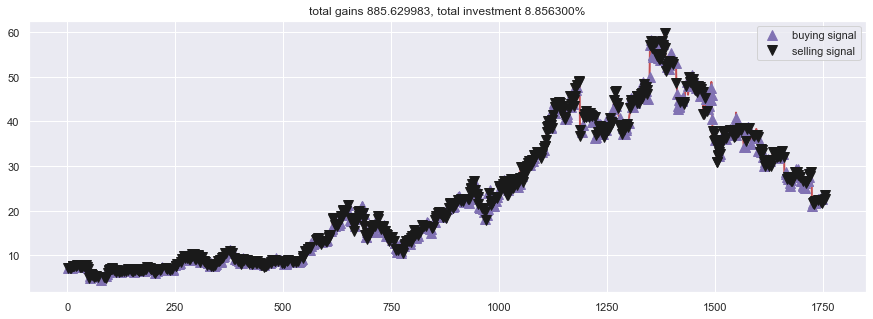

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()